In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle
from sklearn.metrics import r2_score

In [9]:
plt.rcParams.update({'font.size': 16})
linewidth=2

In [10]:
sig_data="/mnt/shared/lvaughan/Pileup_ntuples/diHiggs_analysis_ntuples/dataset_diHiggs_mu60_NumEvents20k_Eval_MinJetpT25.root:fastjet"
sig_scores="/mnt/shared/lvaughan/Pileup_ntuples/diHiggs_analysis_ntuples/DiHiggs_Scores.root:jet_scores"
bkg_data="/mnt/shared/lvaughan/Pileup_ntuples/diHiggs_analysis_ntuples/dataset_4b_mu60_NumEvents20k_Eval_MinJetpT25.root:fastjet"
bkg_scores="/mnt/shared/lvaughan/Pileup_ntuples/diHiggs_analysis_ntuples/4b_Scores.root:jet_scores"

In [11]:
with uproot.open( sig_scores ) as f:
    sig_baseline = f['Baseline_Classifier'].array(library='np')
    sig_pred = f['Pred_Classifier'].array(library='np')
    sig_true = f['Truth_Classifier'].array(library='np')

with uproot.open( bkg_scores ) as f:
    bkg_baseline = f['Baseline_Classifier'].array(library='np')
    bkg_pred = f['Pred_Classifier'].array(library='np')
    bkg_true = f['Truth_Classifier'].array(library='np')

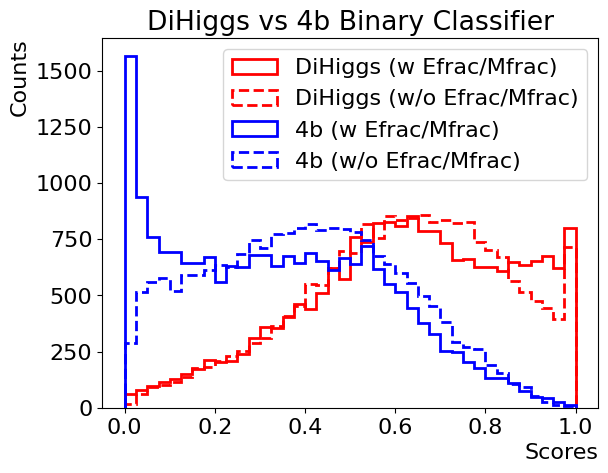

In [12]:
plt.figure()
plt.title("DiHiggs vs 4b Binary Classifier")
plt.hist(sig_pred,color='r',histtype='step',label='DiHiggs (w Efrac/Mfrac)',bins=40,range=(0,1),linewidth=linewidth)
plt.hist(sig_baseline,color='r',histtype='step',label='DiHiggs (w/o Efrac/Mfrac)',bins=40,range=(0,1),linestyle='--',linewidth=linewidth)
plt.hist(bkg_pred,color='b',histtype='step',label='4b (w Efrac/Mfrac)',bins=40,range=(0,1),linewidth=linewidth)
plt.hist(bkg_baseline,color='b',histtype='step',label='4b (w/o Efrac/Mfrac)',bins=40,range=(0,1),linestyle='--',linewidth=linewidth)
#plt.hist(sig_true,color='k',histtype='step',label='DiHiggs (truth)',bins=30,range=(0,1),linewidth=linewidth)
#plt.hist(bkg_true,color='k',histtype='step',label='4b (truth)',bins=30,linestyle='--',range=(0,1),linewidth=linewidth)
#plt.yscale('log')
plt.xlabel("Scores",loc='right')
plt.ylabel("Counts",loc='top')
plt.legend()
plt.show()

In [6]:
def ATLAS_roc(y_true, y_pred):
    sig = (y_true==1)
    bkg = ~sig
    
    sig_eff = []
    bkg_eff = []
    
    thresholds = np.linspace(0,0.9,100)
    
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        bkg_eff.append(1-((y_pred[bkg] < threshold).sum() / y_true[bkg].shape[0]))

    bkg_rej = [1/x for x in bkg_eff]
    return np.array(sig_eff), np.array(bkg_rej), thresholds

In [7]:
sig = np.ones(len(sig_baseline))
bkg = np.zeros(len(bkg_baseline))
labels = np.concatenate([sig,bkg],axis=0)
y_true = np.concatenate([sig_true,bkg_true],axis=0)
y_pred = np.concatenate([sig_pred,bkg_pred],axis=0)
y_baseline = np.concatenate([sig_baseline,bkg_baseline],axis=0)

In [22]:
plt.rcParams.update({'font.size': 24})
linewidth=4

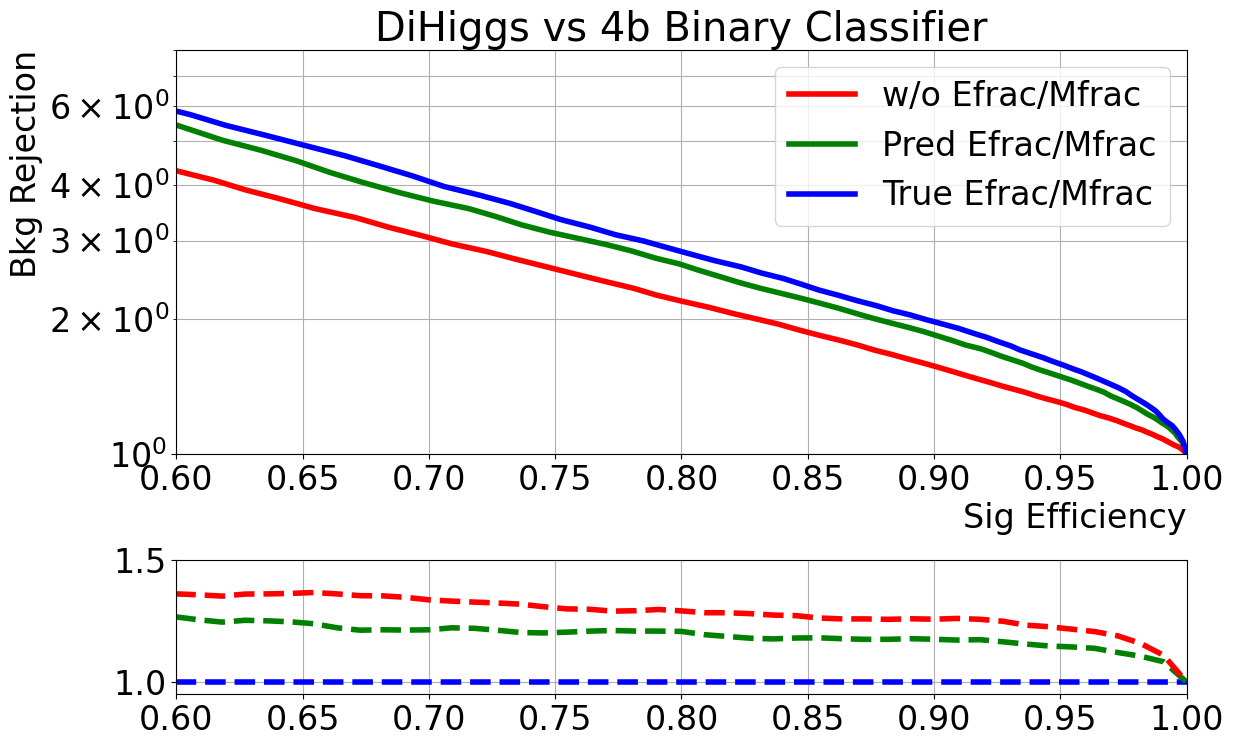

In [25]:
x1,y1,th1 = ATLAS_roc(labels,y_baseline)
x2,y2,th2 = ATLAS_roc(labels,y_pred)
x3,y3,th3 = ATLAS_roc(labels,y_true)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,8), gridspec_kw={'height_ratios': [3, 1]})
#fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]})
fig.tight_layout(pad=1.5)

ax1.set_title("DiHiggs vs 4b Binary Classifier")
ax1.plot(x1,y1,color='r',label='w/o Efrac/Mfrac',linewidth=linewidth)
ax1.plot(x2,y2,color='g',label='Pred Efrac/Mfrac',linewidth=linewidth)
ax1.plot(x3,y3,color='b',label='True Efrac/Mfrac',linewidth=linewidth)


ax1.set_ylabel('Bkg Rejection',loc='top')
ax1.set_xlabel('Sig Efficiency',loc='right')
ax1.set_yscale('log')
ax1.legend(loc='upper right')
ax1.set_xlim([0.6, 1])
ax1.set_ylim([1, 8])

# Plot ratio plot
x = 1-np.flip(th1)
ratio1 = np.interp(x,np.flip(x1),np.flip(y1))/np.interp(x,np.flip(x1),np.flip(y1))
ratio2 = np.interp(x,np.flip(x2),np.flip(y2))/np.interp(x,np.flip(x1),np.flip(y1))
ratio3 = np.interp(x,np.flip(x3),np.flip(y3))/np.interp(x,np.flip(x1),np.flip(y1))

ax2.plot(x,ratio1,linestyle='--',color='b',linewidth=linewidth)
ax2.plot(x,ratio2,linestyle='--',color='g',linewidth=linewidth)
ax2.plot(x,ratio3,linestyle='--',color='r',linewidth=linewidth)

ax2.set_ylim([0.95, 1.5])
ax2.set_xlim([0.6, 1])

ax1.grid(which='both')
ax2.grid(which='both')
plt.show()